In [2]:

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.lines as mlines
from multiprocessing import Pool

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import test_test_split
from sklearn.preprocessing import StandardScaler

from time import time

import gdown

from helper_functions.general import touch_dir

from joblib import Parallel, delayed
from tqdm import tqdm

import sys, importlib
# importlib.reload(sys.modules['utils'])
from utils import def_grids_and_interp, get_box_from_grid, sample_random_subgrids, get_grid_from_box, interp_fun

import h5py

DTYPE = 'float32'


2024-03-27 14:53:09.807739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 14:53:10.254349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-03-27 14:53:11.533826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 14:53:11.556451: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ImportError: cannot import name 'test_test_split' from 'sklearn.model_selection' (/home/bonotto/workspace/miniconda3/envs/planet/lib/python3.9/site-packages/sklearn/model_selection/__init__.py)

In [ ]:
# !wget 'https://www.dropbox.com/scl/fi/6da6pqks1rovyncu1q93n/ITER_like_equilibrium_dataset.mat?rlkey=qnc9hz0pb6jdlq4ki7jz390xq&dl=0'

# filename = '../data/ITER_like_equilibrium_dataset.mat'
filename = '../data/ITER_like_equilibrium_dataset.h5'

if not os.path.isfile(filename):
    touch_dir('data/')
    id = '1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue'
    gdown.download(
        # id=id, 
        url = 'https://drive.google.com/file/d/1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue/view?usp=sharing',
        output=filename, 
        quiet=False, 
        verify=False
        )

# data = io.loadmat(filename)



In [ ]:
# with h5py.File('ITER_like_equilibrium_dataset.h5','w') as handle:
#     for k,v in data.items():
#         if '__' not in k:
#             print(k)
#             chunks = [1]
#             chunks.extend(list(v.shape[1:]))
#             handle.create_dataset(
#                 k,
#                 data = v,
#                 shape = v.shape,
#                 chunks = tuple(chunks),
#                 dtype = 'float64'
#             )


In [ ]:
n_sample_test = 5000

with h5py.File(filename, 'r') as handle:
    DB_psi_pixel_test_ConvNet = handle['DB_psi_pixel_test_ConvNet'][()].astype(DTYPE)
    DB_meas_Bpickup_test_ConvNet = handle['DB_meas_Bpickup_test_ConvNet'][()].astype(DTYPE)
    DB_coils_curr_test_ConvNet = handle['DB_coils_curr_test_ConvNet'][()].astype(DTYPE)
    DB_p_test_ConvNet = handle['DB_p_test_ConvNet'][()].astype(DTYPE)
    RR_pixels = handle['RR_pixels'][()].astype(DTYPE)
    ZZ_pixels = handle['ZZ_pixels'][()].astype(DTYPE)
    DB_res_RHS_pixel_test_ConvNet = handle['DB_res_RHS_pixel_test_ConvNet'][()].astype(DTYPE)
    DB_separatrix_200_test_ConvNet = handle['DB_separatrix_200_test_ConvNet'][()].astype(DTYPE)
    DB_Jpla_pixel_test_ConvNet = handle['DB_Jpla_pixel_test_ConvNet'][()].astype(DTYPE)


y_data = DB_psi_pixel_test_ConvNet
X_data = np.column_stack((
    DB_meas_Bpickup_test_ConvNet,
    DB_coils_curr_test_ConvNet,
    # DB_f_test_ConvNet,
    DB_p_test_ConvNet
    ))


# Save RR_pixels, ZZ_pixels
outdir = '../data/'
dict_save = {
    'RR_pixels':RR_pixels,
    'ZZ_pixels':ZZ_pixels,
             }
nr,nz = RR_pixels.shape
io.savemat('{}data_geo_Dataset_NeuralOpt_super_res_{}x{}.mat'.format(
    outdir,nr,nz
),dict_save)   

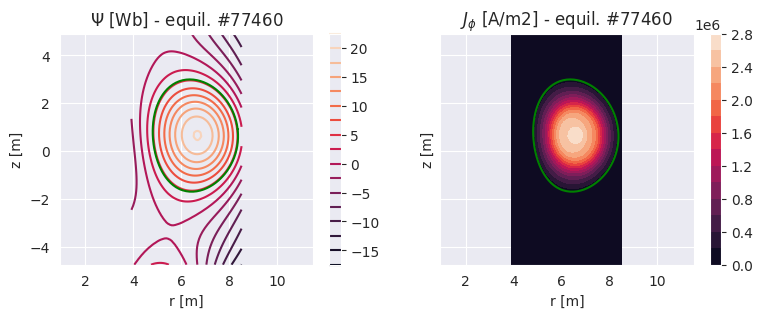

In [ ]:


for i in range(0,1):
    ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    img = axs[0].contour(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[0].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('$\Psi$ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RR_pixels,ZZ_pixels,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_\phi$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')




In [ ]:
# def fun_contourf_sol(z,RR,ZZ):
#     plt.figure()
#     plt.contourf(RR, ZZ, z, 20)
#     plt.axis('equal')
#     plt.colorbar()
#     plt.show()
#     return


# def fun_contour_sol(z,RR,ZZ):
#     plt.figure()
#     plt.contour(RR, ZZ, z, 20)
#     plt.axis('equal')
#     plt.colorbar()
#     plt.show()
#     return


# def fun_contour_compare_sol(z_ref,z,RR,ZZ):
#     l1 = mlines.Line2D([], [], label='DNN')
#     l2 = mlines.Line2D([], [], color='black', label='FRIDA')

#     plt.figure()
#     plt.contour(RR, ZZ, z, 10)
#     plt.colorbar()
#     plt.contour(RR, ZZ, z_ref, 10, colors = 'black', linestyles = 'dashed')
#     plt.legend(handles=[l1, l2])
#     plt.axis('equal')
#     plt.show()
#     return

In [ ]:
### test-test split
if not os.path.isfile('{}/id_test.npy'.format(outdir)):
    ID = np.arange(DB_res_RHS_pixel_test_ConvNet.shape[0])

    id_train, id_test = train_test_split(
        ID,
        test_size=.2,
        random_state=42)

    np.save('{}/id_train.npy'.format(outdir), id_train)
    np.save('{}/id_test.npy'.format(outdir), id_test)

else:
    id_train = np.load('{}/id_train.npy'.format(outdir))
    id_test = np.load('{}/id_test.npy'.format(outdir))



In [ ]:
# def prepare_dataloader_TF(
#     DB_psi_pixel_test_ConvNet,
#     DB_meas_Bpickup_test_ConvNet,
#     DB_coils_curr_test_ConvNet,
#     DB_p_test_ConvNet,
#     id_train,
#     id_test,
#     n_sample_train,
# ):

#     y_data = DB_psi_pixel_test_ConvNet
#     X_data = np.column_stack((
#         DB_meas_Bpickup_test_ConvNet,
#         DB_coils_curr_test_ConvNet,
#         DB_p_test_ConvNet
#         ))
    
#     ### Standardize input data
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X_data)
#     np.mean(X[:,0])

#     ### Train-test split
#     ID = np.arange(X.shape[0])

#     # id_train, id_test = train_test_split(
#     #     ID,
#     #     test_size=.2,
#     #     random_state=42)

#     X_train = X[id_train, ...]
#     X_test = X[id_test, ...]
#     y_train = y_data[id_train, ...]
#     y_test = y_data[id_test, ...]

#     res_RHS_pixel_train = DB_res_RHS_pixel_test_ConvNet[np.int_(id_train), ...]
#     res_RHS_D_train = DB_res_RHS_pixel_test_ConvNet[np.int_(id_train), ...]

#     res_RHS_pixel_test = DB_res_RHS_pixel_test_ConvNet[np.int_(id_test), ...]
#     res_RHS_D_test = DB_res_RHS_pixel_test_ConvNet[np.int_(id_test), ...]


#     '''
#     The full training dataset is ~60k equilibria. We select 35k equilibria on the full grid
#     and 35k equilibria to be resampled on randomly generated sub-grids. These two datasets 
#     are then put together ans shuffled.

#     _all_domain -> quantities related to the original grid
#     _super_res -> quantities related to random sub-grids

#     It woul be nice to explore how the performance changes using data different from the 
#     aforementioned 35k/35k.
#     '''

#     np.random.seed(42)

#     # generate 
#     ind_rand_all = np.random.randint(
#         0,y_train.shape[0],y_train.shape[0]
#         )

#     ind_all_domain = ind_rand_all[:y_train.shape[0]//2] # select indices for the full grid
#     ind_super_res = ind_rand_all[y_train.shape[0]//2:] # select indices for the full grid


#     ind_all_domain = ind_rand_all[
#         np.random.randint(0,y_train.shape[0],n_sample_train) # indices for the full grid
#         ]
#     ind_super_res = ind_rand_all[
#         np.random.randint(0,y_train.shape[0],n_sample_train) # indices for the sub-grids
#         ]

#     n_all_domain = ind_all_domain.shape[0]
#     n_super_res = ind_super_res.shape[0]

#     print(f'{n_all_domain} equil on the original grid')
#     print(f'{n_super_res} equil on random sub-grids')

#     y_train_all_domain = y_train[ind_all_domain,:,:]
#     X_train_all_domain = X_train[ind_all_domain,:]
#     res_RHS_pixel_train_all_domain = res_RHS_pixel_train[ind_all_domain,:,:]

#     f_for_super_res = y_train[ind_super_res,:,:]
#     rhs_for_super_res = res_RHS_D_train[ind_super_res,:,:]

#     X_train_super_res = X_train[ind_super_res,:]
#     y_train_super_res = np.zeros((n_super_res,64,64), dtype=DTYPE)
#     rhs_train_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
#     RR_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
#     ZZ_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)


#     '''
#     Define n_sample_train random subgrids and perform interpolation of 
#     the original equilibrium on a random sub-grid
#     '''
#     PARALLEL = False
#     if PARALLEL: # -> it may crash on average computers
#         import warnings
#         warnings.filterwarnings("ignore", category=DeprecationWarning) 

#         pool = Pool(processes=6)
#         results = [pool.apply_async(def_grids_and_interp, [f_i,rhs_i,RR_pixels,ZZ_pixels,64,64]) for \
#             f_i,rhs_i in zip(f_for_super_res,rhs_for_super_res)]

#         t_start = time()
#         for idx, val in enumerate(results):
#             rr_grid, zz_grid, f_grid, rhs_grid = val.get()
#             RR_grid_super_res[idx,:,:] = rr_grid
#             ZZ_grid_super_res[idx,:,:] = zz_grid
#             y_train_super_res[idx,:,:] = f_grid
#             rhs_train_super_res[idx,:,:] = rhs_grid

#         t_elapsed = time() - t_start
#         print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')
        
#     else:

#         t_start = time()
#         for i in tqdm(
#             range(f_for_super_res.shape[0]),
#             miniters = 0):
#             rr_grid, zz_grid, f_grid, rhs_grid = def_grids_and_interp(
#                 f_for_super_res[i,...],
#                 rhs_for_super_res[i,...],
#                 RR_pixels,
#                 ZZ_pixels
#                 )
#             RR_grid_super_res[i,:,:] = rr_grid
#             ZZ_grid_super_res[i,:,:] = zz_grid
#             y_train_super_res[i,:,:] = f_grid
#             rhs_train_super_res[i,:,:] = rhs_grid

#         t_elapsed = time() - t_start
#         print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')


#     RR_grid_all_domain = np.tile(RR_pixels,(n_all_domain,1,1))
#     ZZ_grid_all_domain = np.tile(ZZ_pixels,(n_all_domain,1,1))



In [ ]:
### Standardize input data
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

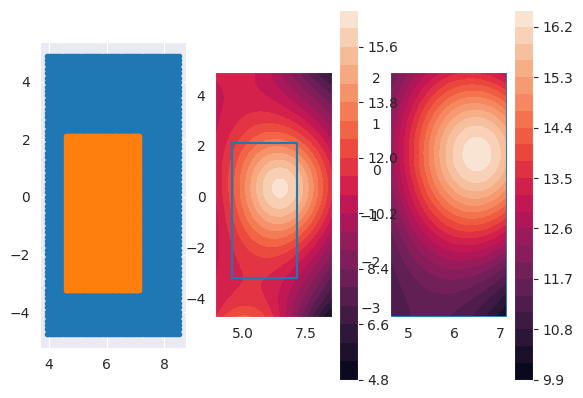

In [ ]:
f = y_data[0,:,:]
rr_grid, zz_grid = sample_random_subgrids(RR_pixels,ZZ_pixels)
box = get_box_from_grid(rr_grid, zz_grid)
f_grid = interp_fun(f,RR_pixels,ZZ_pixels,rr_grid, zz_grid,kind='quintic')

fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].set_aspect('equal', 'box')

im = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[1])

im = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])

plt.show()

In [ ]:
'''
The full training dataset is ~60k equilibria. We select 35k equilibria on the full grid
and 35k equilibria to be resampled on randomly generated sub-grids. These two datasets 
are then put together ans shuffled.

_all_domain -> quantities related to the original grid
_super_res -> quantities related to random sub-grids

It woul be nice to explore how the performance changes using data different from the 
aforementioned 35k/35k.
'''
np.random.seed(42)
ind_all_domain = np.random.choice(id_train,n_sample_train)

np.random.seed(43)
ind_super_res = np.random.choice(id_train,n_sample_train)

n_all_domain = ind_all_domain.shape[0]
n_super_res = ind_super_res.shape[0]

print(f'{n_all_domain} equil on the original grid')
print(f'{n_super_res} equil on random sub-grids')

y_train_all_domain = y_data[ind_all_domain,:,:]
X_train_all_domain = X_data[ind_all_domain,:]
res_RHS_pixel_train_all_domain = DB_res_RHS_pixel_test_ConvNet[ind_all_domain,:,:]

y_test_all_domain = y_data[id_test,:,:]
X_test_all_domain = X_data[id_test,:]
res_RHS_pixel_test_all_domain = DB_res_RHS_pixel_test_ConvNet[id_test,:,:]

f_for_super_res = y_data[ind_super_res,:,:]
rhs_for_super_res = DB_res_RHS_pixel_test_ConvNet[ind_super_res,:,:]

X_train_super_res = X_data[ind_super_res,:]
y_train_super_res = np.zeros((n_super_res,64,64), dtype=DTYPE)
rhs_train_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
RR_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
ZZ_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)

5000 equil on the original grid
5000 equil on random sub-grids


In [ ]:
# n_parallel = os.cpu_count()

# t_start = time()
# rr_grid, zz_grid, f_grid, rhs_grid = zip(
#     *Parallel(n_jobs=n_parallel)(delayed(def_grids_and_interp)(
#         f_i,rhs_i,RR_pixels,ZZ_pixels,64,64
#         ) for f_i,rhs_i in tqdm(zip(f_for_super_res,rhs_for_super_res)))
# )

# t_elapsed = time() - t_start
# print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')

In [ ]:
PARALLEL = False

if PARALLEL: # -> it may crash on average computers
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 

    pool = Pool(processes=6)
    results = [pool.apply_async(def_grids_and_interp, [f_i,rhs_i,RR_pixels,ZZ_pixels,64,64]) for \
        f_i,rhs_i in zip(f_for_super_res,rhs_for_super_res)]

    t_start = time()
    for idx, val in enumerate(results):
        rr_grid, zz_grid, f_grid, rhs_grid = val.get()
        RR_grid_super_res[idx,:,:] = rr_grid
        ZZ_grid_super_res[idx,:,:] = zz_grid
        y_train_super_res[idx,:,:] = f_grid
        rhs_train_super_res[idx,:,:] = rhs_grid

    t_elapsed = time() - t_start
    print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')
    
else:

    t_start = time()
    for i in tqdm(
        range(f_for_super_res.shape[0]),
        miniters = 0):
        rr_grid, zz_grid, f_grid, rhs_grid = def_grids_and_interp(
            f_for_super_res[i,...],
            rhs_for_super_res[i,...],
            RR_pixels,
            ZZ_pixels
            )
        RR_grid_super_res[i,:,:] = rr_grid
        ZZ_grid_super_res[i,:,:] = zz_grid
        y_train_super_res[i,:,:] = f_grid
        rhs_train_super_res[i,:,:] = rhs_grid

    t_elapsed = time() - t_start
    print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')


RR_grid_all_domain = np.tile(RR_pixels,(n_all_domain,1,1))
ZZ_grid_all_domain = np.tile(ZZ_pixels,(n_all_domain,1,1))


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:03<00:00, 1486.03it/s]

t_elapsed = 3.3669092655181885, time_per_step = 0.0006733818531036377


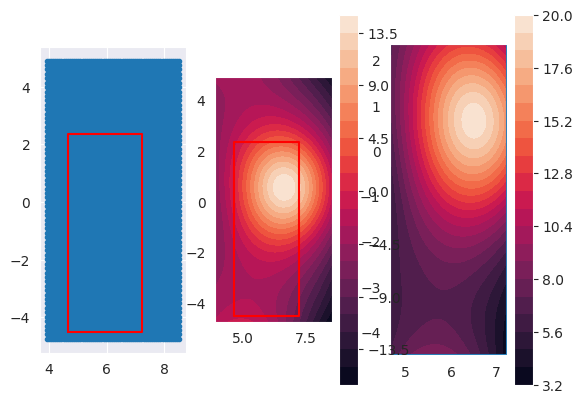

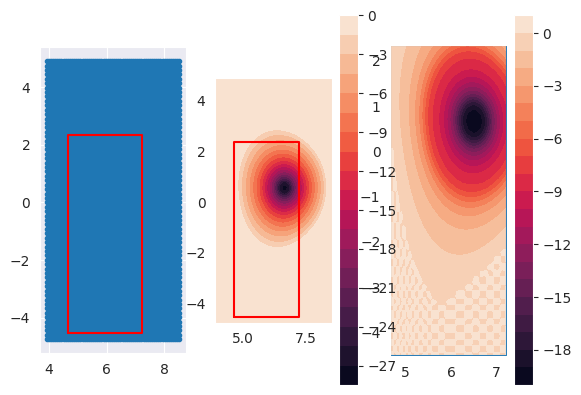

In [ ]:
### Check re-sampled equils

i = 0

f = f_for_super_res[i,:,:]
rhs = rhs_for_super_res[i,:,:]

rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]

box = get_box_from_grid(rr_grid, zz_grid)

fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
# ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].plot(box[:,0],box[:,1],c='r')
ax[0].set_aspect('equal', 'box')

im = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[1])

im = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])

plt.show()


fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
# ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].plot(box[:,0],box[:,1],c='r')
ax[0].set_aspect('equal', 'box')

im = ax[1].contourf(RR_pixels, ZZ_pixels, rhs, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[1])

im = ax[2].contourf(rr_grid, zz_grid, rhs_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])

plt.show()


In [ ]:
y_train = np.row_stack([y_train_all_domain,y_train_super_res])
X_train = np.row_stack([X_train_all_domain,X_train_super_res])
res_RHS_pixel_train = np.row_stack([res_RHS_pixel_train_all_domain,rhs_train_super_res])
RR_pixel_train = np.row_stack([RR_grid_all_domain,RR_grid_super_res])
ZZ_pixel_train = np.row_stack([ZZ_grid_all_domain,ZZ_grid_super_res])

print(X_train.shape,
      y_train.shape,
      res_RHS_pixel_train[:,1:-1,1:-1].shape,
      RR_pixel_train.shape,
      ZZ_pixel_train.shape,
      )


'''
Compute kernels for GS Equation for the qeuils on the sub-grids (dr,dz is grid-dependent), 
otherwise we would have to compute them on the fly during each training step

'''
Laplace_kernel = np.zeros((y_train.shape[0],3,3),dtype=DTYPE)
Df_dr_kernel = np.zeros((y_train.shape[0],3,3),dtype=DTYPE)

for i in tqdm(range(y_train.shape[0])):
    hr = RR_pixel_train[i,1,2] - RR_pixel_train[i,1,1]
    hz = ZZ_pixel_train[i,2,1] - ZZ_pixel_train[i,1,1] 
    alfa = -2*(hr**2 + hz**2)
    Laplace_kernel_i = np.array(([0, hr**2/alfa, 0], [hz**2/alfa, 1, hz**2/alfa], [0, hr**2/alfa, 0]))
    Df_dr_kernel_i = np.array(([0, 0, 0], [+1, 0, -1], [0, 0, 0]))/(2*hr*alfa)*(hr**2*hz**2)

    Laplace_kernel[i,:,:] = Laplace_kernel_i
    Df_dr_kernel[i,:,:] = Df_dr_kernel_i

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train,
     y_train,
     res_RHS_pixel_train[:,1:-1,1:-1],
     RR_pixel_train,
     ZZ_pixel_train,
     Laplace_kernel,
     Df_dr_kernel,
     )).shuffle(42)#.batch(batch_size=1024)

tf.data.Dataset.save(train_ds, '{}tf_Dataset_train_NeuralOpt_{}x{}_{}_samples.data'.format(
    outdir,nr,nz, X_train.shape[0]
))

(10000, 302) (10000, 64, 64) (10000, 62, 62) (10000, 64, 64) (10000, 64, 64)


100%|██████████| 10000/10000 [00:00<00:00, 77507.09it/s]
2024-03-27 14:22:58.791109: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2024-03-27 14:22:58.908014: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153760000 exceeds 10% of free system memory.
2024-03-27 14:22:59.037781: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2024-03-27 14:22:59.151907: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2024-03-27 14:22:59.239810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.


In [ ]:
y_test = y_test_all_domain
X_test = X_test_all_domain
res_RHS_pixel_test = res_RHS_pixel_test_all_domain

### Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_test,
     y_test,
     res_RHS_pixel_test[:,1:-1,1:-1],
     )).shuffle(42)#.batch(batch_size=1024)

tf.data.Dataset.save(train_ds, '{}tf_Dataset_test_NeuralOpt_{}x{}_{}_samples.data'.format(
    outdir,nr,nz, X_train.shape[0]
))

NameError: name 'y_test_all_domain' is not defined